# Non-linear features

This notebook demonstrates how to use YASA to calculate epoch-per-epoch non-linear features of a full-night single-channel EEG recording.

Please make sure to install the latest version of YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`

In addition, you will also need to install the [AntroPy](https://github.com/raphaelvallat/antropy) package: `pip install --upgrade antropy`

In [1]:
# import yasa
import numpy as np
import pandas as pd
import antropy as ant
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

# Load EEG data
f = np.load('data_full_6hrs_100Hz_Cz+Fz+Pz.npz')
data, ch_names = f['data'], f['chan']
sf = 100.
times = np.arange(data.size) / sf

# Keep only Cz
data = data[0, :]
print(data.shape, np.round(data[0:5], 3))

(2161058,) [15.797 22.307 39.922 25.657 27.094]


In [3]:
# # Load the hypnogram data
# hypno = np.loadtxt('data_full_6hrs_100Hz_hypno_30s.txt').astype(int)
# print(hypno.shape, 'Unique values =', np.unique(hypno))

In [4]:
# Convert the EEG data to 30-sec data

def sliding_window(data, sf, window, step=None, axis=-1):
    """Calculate a sliding window of a 1D or 2D EEG signal.
    .. versionadded:: 0.1.7
    Parameters
    ----------
    data : numpy array
        The 1D or 2D EEG data.
    sf : float
        The sampling frequency of ``data``.
    window : int
        The sliding window length, in seconds.
    step : int
        The sliding window step length, in seconds.
        If None (default), ``step`` is set to ``window``,
        which results in no overlap between the sliding windows.
    axis : int
        The axis to slide over. Defaults to the last axis.
    Returns
    -------
    times : numpy array
        Time vector, in seconds, corresponding to the START of each sliding
        epoch in ``strided``.
    strided : numpy array
        A matrix where row in last dimension consists of one instance
        of the sliding window, shape (n_epochs, ..., n_samples).
    Notes
    -----
    This is a wrapper around the
    :py:func:`numpy.lib.stride_tricks.as_strided` function.
    Examples
    --------
    With a 1-D array
    >>> import numpy as np
    >>> from yasa import sliding_window
    >>> data = np.arange(20)
    >>> times, epochs = sliding_window(data, sf=1, window=5)
    >>> times
    array([ 0.,  5., 10., 15.])
    >>> epochs
    array([[ 0,  1,  2,  3,  4],
           [ 5,  6,  7,  8,  9],
           [10, 11, 12, 13, 14],
           [15, 16, 17, 18, 19]])
    >>> sliding_window(data, sf=1, window=5, step=1)[1]
    array([[ 0,  1,  2,  3,  4],
           [ 2,  3,  4,  5,  6],
           [ 4,  5,  6,  7,  8],
           [ 6,  7,  8,  9, 10],
           [ 8,  9, 10, 11, 12],
           [10, 11, 12, 13, 14],
           [12, 13, 14, 15, 16],
           [14, 15, 16, 17, 18]])
    >>> sliding_window(data, sf=1, window=11)[1]
    array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])
    With a N-D array
    >>> np.random.seed(42)
    >>> # 4 channels x 20 samples
    >>> data = np.random.randint(-100, 100, size=(4, 20))
    >>> epochs = sliding_window(data, sf=1, window=10)[1]
    >>> epochs.shape  # shape (n_epochs, n_channels, n_samples)
    (2, 4, 10)
    >>> epochs
    array([[[  2,  79,  -8, -86,   6, -29,  88, -80,   2,  21],
            [-13,  57, -63,  29,  91,  87, -80,  60, -43, -79],
            [-50,   7, -46, -37,  30, -50,  34, -80, -28,  66],
            [ -9,  10,  87,  98,  71, -93,  74, -66, -20,  63]],
           [[-26, -13,  16,  -1,   3,  51,  30,  49, -48, -99],
            [-12, -52, -42,  69,  87, -86,  89,  89,  74,  89],
            [-83,  31, -12, -41, -87, -92, -11, -48,  29, -17],
            [-51,   3,  31, -99,  33, -47,   5, -97, -47,  90]]])
    """
    from numpy.lib.stride_tricks import as_strided
    assert axis <= data.ndim, "Axis value out of range."
    assert isinstance(sf, (int, float)), 'sf must be int or float'
    assert isinstance(window, (int, float)), 'window must be int or float'
    assert isinstance(step, (int, float, type(None))), ('step must be int, '
                                                        'float or None.')
    if isinstance(sf, float):
        assert sf.is_integer(), 'sf must be a whole number.'
        sf = int(sf)
    assert isinstance(axis, int), 'axis must be int.'

    # window and step in samples instead of points
    window *= sf
    step = window if step is None else step * sf

    if isinstance(window, float):
        assert window.is_integer(), 'window * sf must be a whole number.'
        window = int(window)

    if isinstance(step, float):
        assert step.is_integer(), 'step * sf must be a whole number.'
        step = int(step)

    assert step >= 1, "Stepsize may not be zero or negative."
    assert window < data.shape[axis], ("Sliding window size may not exceed "
                                       "size of selected axis")

    # Define output shape
    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / step - window / step + 1
                           ).astype(int)
    shape.append(window)

    # Calculate strides and time vector
    strides = list(data.strides)
    strides[axis] *= step
    strides.append(data.strides[axis])
    strided = as_strided(data, shape=shape, strides=strides)
    t = np.arange(strided.shape[-2]) * (step / sf)

    # Swap axis: n_epochs, ..., n_samples
    if strided.ndim > 2:
        strided = np.rollaxis(strided, -2, 0)
    return t, strided

times, data_win = sliding_window(data, sf, window=30)

# Convert times to minutes
times /= 60

data_win.shape

(720, 3000)

## Calculate non-linear features

In [5]:
from numpy import apply_along_axis as apply

df_feat = {
    # Entropy
    'perm_entropy': apply(ant.perm_entropy, axis=1, arr=data_win, normalize=True),
    'svd_entropy': apply(ant.svd_entropy, 1, data_win, normalize=True),
    'sample_entropy': apply(ant.sample_entropy, 1, data_win),
    # Fractal dimension
    'dfa': apply(ant.detrended_fluctuation, 1, data_win),
    'petrosian': apply(ant.petrosian_fd, 1, data_win),
    'katz': apply(ant.katz_fd, 1, data_win),
    'higuchi': apply(ant.higuchi_fd, 1, data_win),
}

df_feat = pd.DataFrame(df_feat)
df_feat.head()

perm_entropy  svd_entropy  sample_entropy       dfa  petrosian      katz  \
0      0.993005     0.615179        0.992649  1.275455   1.027439  2.794894   
1      0.993249     0.565308        0.858924  1.384108   1.027283  2.593635   
2      0.993561     0.573424        0.773124  1.406985   1.027411  2.633458   
3      0.998517     0.495381        0.166400  1.453336   1.028952  2.259923   
4      0.991045     0.737926        1.332437  1.152280   1.026885  3.484544   

    higuchi  
0  1.743780  
1  1.748034  
2  1.721437  
3  1.868283  
4  1.769742

In [5]:
def lziv(x):
    """Binarize the EEG signal and calculate the Lempel-Ziv complexity.
    """
    return ant.lziv_complexity(x > x.mean(), normalize=True)

df_feat['lziv'] = apply(lziv, 1, data_win)

## Add classic spectral power

In [6]:
from scipy.signal import welch
freqs, psd = welch(data_win, sf, nperseg=int(4 * sf))
bp = yasa.bandpower_from_psd_ndarray(psd, freqs)
bp = pd.DataFrame(bp.T, columns=['delta', 'theta', 'alpha', 'sigma', 'beta', 'gamma'])
df_feat = pd.concat([df_feat, bp], axis=1)
df_feat.head()

perm_entropy  svd_entropy  sample_entropy       dfa  petrosian      katz  \
0      0.993005     0.615179        0.992649  1.275455   1.027439  2.794894   
1      0.993249     0.565308        0.858924  1.384108   1.027283  2.593635   
2      0.993561     0.573424        0.773124  1.406985   1.027411  2.633458   
3      0.998517     0.495381        0.166400  1.453336   1.028952  2.259923   
4      0.991045     0.737926        1.332437  1.152280   1.026885  3.484544   

    higuchi      lziv     delta     theta     alpha     sigma      beta  \
0  1.743780  0.565987  0.696338  0.116689  0.066675  0.020174  0.068901   
1  1.748034  0.400426  0.802190  0.068789  0.045489  0.015227  0.045956   
2  1.721437  0.550586  0.877757  0.047858  0.021888  0.007310  0.028541   
3  1.868283  0.431228  0.697172  0.024946  0.041486  0.025344  0.108747   
4  1.769742  0.539035  0.690355  0.098202  0.069255  0.023337  0.082457   

      gamma  
0  0.031222  
1  0.022349  
2  0.016645  
3  0.102304  
4  0.036393

In [7]:
# Ratio of spectral power
# df_feat.eval('dt = delta / theta', inplace=True)
# df_feat.eval('db = delta / beta', inplace=True)
# df_feat.eval('at = alpha / theta', inplace=True)

## Find best features for sleep stage classification

In [6]:
from sklearn.feature_selection import f_classif

# Extract sorted F-values
fvals = pd.Series(f_classif(X=df_feat, y=hypno)[0], 
                  index=df_feat.columns
                 ).sort_values()

# Plot best features
plt.figure(figsize=(6, 6))
sns.barplot(y=fvals.index, x=fvals, palette='RdYlGn')
plt.xlabel('F-values')
plt.xticks(rotation=20);

NameError: name 'hypno' is not defined

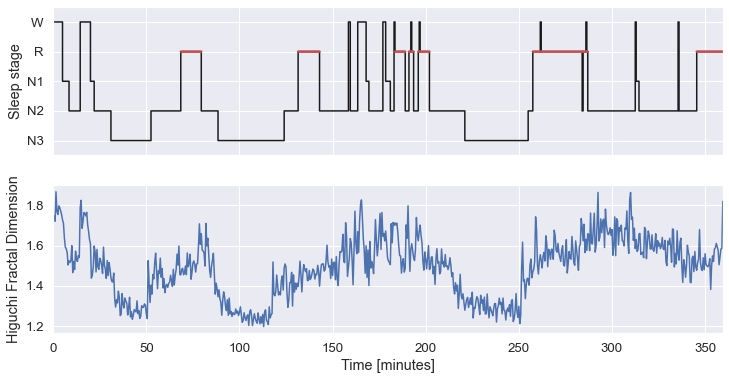

In [9]:
# Plot hypnogram and higuchi
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

hypno = pd.Series(hypno).map({-1: -1, 0: 0, 1: 2, 2: 3, 3: 4, 4: 1}).values
hypno_rem = np.ma.masked_not_equal(hypno, 1)

# Plot the hypnogram
ax1.step(times, -1 * hypno, color='k', lw=1.5)
ax1.step(times, -1 * hypno_rem, color='r', lw=2.5)
ax1.set_yticks([0, -1, -2, -3, -4])
ax1.set_yticklabels(['W', 'R', 'N1', 'N2', 'N3'])
ax1.set_ylim(-4.5, 0.5)
ax1.set_ylabel('Sleep stage')

# Plot the non-linear feature
ax2.plot(times, df_feat['higuchi'])
ax2.set_ylabel('Higuchi Fractal Dimension')
ax2.set_xlabel('Time [minutes]')

ax2.set_xlim(0, times[-1]);